# **VC Benchmark**


# **Overview**

This notebook builds a synthetic yet realistic **benchmarking system** used for evaluating venture capital portfolios. It includes four interlinked tables that simulate how institutional asset managers compare fund performance against sectoral or regional indices.


### Summary of Benchmark Tables

| Table Name                  | Description                                                                 | Key Purpose                                  |
|----------------------------|-----------------------------------------------------------------------------|----------------------------------------------|
| **BENCHMARKGENERALINFORMATION** | 20 synthetic benchmarks with sector/geography-based names and unique codes | Define the benchmark universe                |
| **BENCHMARKCHARACTERISTICS**   | Summary statistics like Median IRR, MOIC, Fund Count, with units and currencies | Add context and comparability to benchmarks  |
| **BENCHMARKPERFORMANCE**       | Simulated returns (IRR, MOIC, etc.) across multiple time periods             | Enable time-series performance analysis      |
| **BENCHMARKASSOCIATION**       | Links 100 portfolio funds to 1–3 benchmarks with ranked relevance           | Enable fund-vs-benchmark comparisons         |

Each table mimics data structures used in real VC analytics tools—supporting return attribution, benchmarking, and client reporting in a controlled simulation environment.

---


## **Table 1: BENCHMARKGENERALINFORMATION**

The `BENCHMARKGENERALINFORMATION` table defines a clean list of 20 **synthetic benchmarks** that Venture Capital (VC) funds in our simulation can be evaluated against. Each row represents a benchmark commonly used in institutional performance reporting—defined by sector, geography, or both.


### Generation Logic

We simulate **20 unique benchmark records**, each created using one of three random patterns:

| Pattern Type | Name Example                                                 | Code Example    |
|--------------|--------------------------------------------------------------|-----------------|
| `geo`        | PitchBook Europe VC Benchmark                                | `PB_EU`         |
| `sector`     | Preqin CleanTech VC Performance Index                        | `PR_CT`         |
| `combo`      | Cambridge Associates North America Healthcare Growth Index   | `CA_NA_HC`      |

### Key Logic and Validation

| Step | Description |
|------|-------------|
| **1. Provider Prefix** | Extracts a stable 2-letter code from the provider name:<br>e.g., `"PitchBook"` → `"PB"` |
| **2. Geography Mapping** | Maps region names like `"Asia-Pacific"` to short codes like `"AP"` |
| **3. Sector Mapping** | Maps sectors like `"Healthcare"` to codes like `"HC"` |
| **4. Benchmark Code Construction** | Combines provider, region, and/or sector codes to form a machine-readable `BENCHMARKCODE` |
| **5. Uniqueness Enforcement** | Appends a numeric suffix (e.g., `_2`, `_3`) if a generated code already exists |

In [ ]:
import pandas as pd
import numpy as np
import random
import re
from IPython.display import display, HTML

# Ensure reproducibility
random.seed(42)
np.random.seed(42)

def get_provider_prefix(name: str) -> str:
    """
    Data Validation Logic 1:
    Derive a stable 2-letter prefix from a provider name by:
      - Extracting the first two uppercase letters if available (e.g., 'PitchBook' → 'PB')
      - Otherwise falling back to the first two characters uppercased.
    """
    caps = re.findall(r'[A-Z]', name)
    if len(caps) >= 2:
        return ''.join(caps[:2])
    return name[:2].upper()

# Map full geography names to 2-letter codes
region_map = {
    "U.S.":             "US",
    "North America":    "NA",
    "Global":           "GL",
    "Asia-Pacific":     "AP",
    "Europe":           "EU",
    "Emerging Markets": "EM",
    "Canada":           "CA"
}

# Pools of inputs
providers        = ["PitchBook", "Cambridge Associates", "Preqin", "CB Insights", "CB Insights", "Carta"]
geographies      = list(region_map.keys())
sectors          = ["Tech", "Healthcare", "CleanTech", "AI", "Growth Equity"]

# Explicit sector code map for clarity in codes
sector_code_map = {
    "Tech":           "TE",
    "Healthcare":     "HC",
    "CleanTech":      "CT",
    "AI":             "AI",
    "Life Sciences":  "LS",
    "Growth Equity":  "GE"
}

# Suffix pools for different naming patterns
geo_suffixes     = ["Venture Capital Index", "VC Benchmark", "Private Equity Index", "Growth Equity Index", "Private Capital Index"]
sector_suffixes  = ["VC Performance Index", "Venture Capital Index", "Private Equity Index", "Growth Equity Benchmark"]
combo_suffixes   = ["Venture Capital Index", "Growth Index", "VC Performance Index"]

benchmark_names = []
benchmark_codes = []
used_codes      = set()

# Generate at least 20 benchmark entries
for _ in range(20):
    provider = random.choice(providers)
    pattern  = random.choice(["geo", "sector", "combo"])

    if pattern == "geo":
        # Geography-only naming
        region_full = random.choice(geographies)
        suffix      = random.choice(geo_suffixes)
        name        = f"{provider} {region_full} {suffix}"

        # Build code: provider prefix + geography code
        pfx = get_provider_prefix(provider)
        rfx = region_map[region_full]
        base_code = f"{pfx}_{rfx}"

    elif pattern == "sector":
        # Sector-only naming
        sector_full = random.choice(sectors)
        suffix      = random.choice(sector_suffixes)
        name        = f"{provider} {sector_full} {suffix}"

        # Build code: provider prefix + sector code (explicit map)
        pfx = get_provider_prefix(provider)
        sfx = sector_code_map[sector_full]
        base_code = f"{pfx}_{sfx}"

    else:
        # Geography + sector naming
        region_full = random.choice(geographies)
        sector_full = random.choice(sectors)
        suffix      = random.choice(combo_suffixes)
        name        = f"{provider} {region_full} {sector_full} {suffix}"

        # Build code: provider + geography + sector codes
        pfx = get_provider_prefix(provider)
        rfx = region_map[region_full]
        sfx = sector_code_map[sector_full]
        base_code = f"{pfx}_{rfx}_{sfx}"

    # Data Validation Logic 4: make sure each BENCHMARKCODE is unique
    code = base_code
    counter = 1
    while code in used_codes:
        counter += 1
        code = f"{base_code}_{counter}"
    used_codes.add(code)

    benchmark_names.append(name)
    benchmark_codes.append(code)

# Assemble into a DataFrame
df_benchmark_general = pd.DataFrame({
    "BENCHMARKCODE":  benchmark_codes,
    "BENCHMARKNAME":  benchmark_names
})

# Display table
print("BENCHMARKGENERALINFORMATION")
display(HTML(df_benchmark_general.to_html(index=False)))

BENCHMARKGENERALINFORMATION


BENCHMARKCODE,BENCHMARKNAME
CA_US,Carta U.S. Private Equity Index
CA_NA,Cambridge Associates North America Venture Capital Index
CA_EU_TE,Carta Europe Tech VC Performance Index
CB_US,CB Insights U.S. Venture Capital Index
CA_EU,Cambridge Associates Europe Private Capital Index
PB_NA_GE,PitchBook North America Growth Equity Growth Index
CA_GE,Cambridge Associates Growth Equity Private Equity Index
PB_EM,PitchBook Emerging Markets Growth Equity Index
PR_HC,Preqin Healthcare Venture Capital Index
PR_US,Preqin U.S. Growth Equity Index


In [ ]:
# Snowflake SQL table creation

# CREATE TABLE BENCHMARKGENERALINFORMATION (
#     BENCHMARKCODE     VARCHAR(50) PRIMARY KEY,  -- Unique identifier (e.g., PB_EU)
#     BENCHMARKNAME     VARCHAR(255)              -- Human-readable name (e.g., PitchBook Europe VC Benchmark)
# );

---

## **Table 2: BENCHMARKCHARACTERISTICS**

The `BENCHMARKCHARACTERISTICS` table contains summary statistics that describe each benchmark’s overall performance and structure. These metrics offer fund-level context—such as typical IRRs, dispersion, and sample sizes—that can be used for comparison in fact sheets or performance dashboards.

Each row represents a specific benchmark–characteristic pair.

### Generation Logic

We simulate 5 characteristics for each of the 20 benchmarks defined in `BENCHMARKGENERALINFORMATION`, resulting in 100 total rows.

| Characteristic Name   | Type        | Example Unit | Notes                                 |
|-----------------------|-------------|--------------|----------------------------------------|
| Median IRR            | Median      | %            | Typical mid-point IRR                  |
| Mean MOIC             | Mean        | %            | Average multiple on invested capital   |
| Top Quartile DPI      | Percentile  | %            | Top 25% value for DPI                  |
| Fund Count            | Count       | #            | Number of funds used in calculation    |
| Std Dev IRR           | StdDevIRR   | %            | Volatility in IRR across funds         |


### Key Logic and Validation

| Step | Description |
|------|-------------|
| **1. Currency Assignment by Region** | Currency is assigned based on the region in the `BENCHMARKNAME` (e.g., benchmarks with “Europe” default to `EUR`) |
| **2. Value Simulation** | Metric values are generated based on realistic VC distributions:<br>– Fund Count uses random integers (40–150)<br>– IRR, MOIC, DPI, StdDev values follow normal distributions around 10% |
| **3. Unit Mapping** | Each `STATISTICTYPE` is mapped to a display unit (`%` or `#`) |
| **4. Benchmark Linkage** | Every row ties back to a valid `BENCHMARKCODE` from the general information table |


This table is intended for statistical comparison and fund evaluation, and it provides the core metadata behind each benchmark’s construction.


In [ ]:
import pandas as pd
import numpy as np
import random
from IPython.display import display, HTML

# Ensure reproducibility for both random and numpy
random.seed(42)
np.random.seed(42)

# Map each statistic type to its unit representation
unit_map = {
    "Median":     "%",   # Median values expressed in percent
    "Mean":       "%",   # Mean values expressed in percent
    "Percentile": "%",   # Percentile values expressed in percent
    "Count":      "#",   # Counts expressed as number of items
    "StdDevIRR":  "%"    # Standard deviation (of IRR) expressed in percent
}

# Currency distribution for characteristics
#  - 80% USD, 5% each of EUR, CAD, JPY, GBP
currency_codes = ["USD", "EUR", "CAD", "JPY", "GBP"]
currency_weights = [0.80,   0.05,  0.05,  0.05,  0.05]
currency_name_map = {
    "USD": "US Dollar",
    "EUR": "Euro",
    "CAD": "Canadian Dollar",
    "JPY": "Japanese Yen",
    "GBP": "British Pound"
}

# Data Validation Logic 1: Default currency by region in benchmark name
region_currency_map = {
    "Europe":           "EUR",
    "Canada":           "CAD",
    "U.S.":             "USD",
    "North America":    "USD",
    "Global":           "USD",
    "Asia-Pacific":     "USD",
    "Emerging Markets": "USD"
}

# Define the set of characteristics we want to capture
char_defs = [
    {"name": "Median IRR",      "type": "Median"},
    {"name": "Mean MOIC",       "type": "Mean"},
    {"name": "Top Quartile DPI","type": "Percentile"},
    {"name": "Fund Count",      "type": "Count"},
    {"name": "Std Dev IRR",     "type": "StdDevIRR"}
]

char_records = []
# Loop over both code and name to apply region-based currency logic
for bench_code, bench_name in zip(benchmark_codes, benchmark_names):
    for char in char_defs:
        # Generate a realistic value based on characteristic type
        if char["type"] == "Count":
            value = np.random.randint(40, 150)  # Fund Count must be integer
        else:
            value = round(np.random.normal(loc=10, scale=2), 2)  # % metrics around 10%

        # Data Validation Logic 2: Determine currency, override if region appears in benchmark name
        currency_code = None
        for region, code in region_currency_map.items():
            if region in bench_name:
                currency_code = code
                break
        if currency_code is None:
            # fallback to weighted random selection when no region keyword found
            currency_code = random.choices(currency_codes, weights=currency_weights, k=1)[0]
        currency_name = currency_name_map[currency_code]

        char_records.append({
            "BENCHMARKCODE":        bench_code,              # link back to BENCHMARKGENERALINFORMATION
            "CURRENCYCODE":         currency_code,           # currency code per record
            "CURRENCY":             currency_name,           # full currency name
            "CATEGORY":             "VC Benchmark",          # grouping category
            "CATEGORYNAME":         "Venture Capital",       # human-readable category
            "CHARACTERISTICNAME":   char["name"],            # e.g., "Median IRR"
            "STATISTICTYPE":        char["type"],            # e.g., "Median"
            "UNIT":                 unit_map[char["type"]],  # e.g., "%"
            "CHARACTERISTICVALUE":  value,                   # the generated value
            "HISTORYDATE":          today                    # snapshot date
        })

# Assemble into a DataFrame
df_benchmark_characteristics = pd.DataFrame(char_records)

# Display table
print("\nBENCHMARKCHARACTERISTICS")
display(HTML(df_benchmark_characteristics.to_html(index=False)))


BENCHMARKCHARACTERISTICS


BENCHMARKCODE,CURRENCYCODE,CURRENCY,CATEGORY,CATEGORYNAME,CHARACTERISTICNAME,STATISTICTYPE,UNIT,CHARACTERISTICVALUE,HISTORYDATE
CA_US,USD,US Dollar,VC Benchmark,Venture Capital,Median IRR,Median,%,10.99,2025-07-17
CA_US,USD,US Dollar,VC Benchmark,Venture Capital,Mean MOIC,Mean,%,9.72,2025-07-17
CA_US,USD,US Dollar,VC Benchmark,Venture Capital,Top Quartile DPI,Percentile,%,11.30,2025-07-17
CA_US,USD,US Dollar,VC Benchmark,Venture Capital,Fund Count,Count,#,142.00,2025-07-17
CA_US,USD,US Dollar,VC Benchmark,Venture Capital,Std Dev IRR,StdDevIRR,%,13.05,2025-07-17
CA_NA,USD,US Dollar,VC Benchmark,Venture Capital,Median IRR,Median,%,8.17,2025-07-17
CA_NA,USD,US Dollar,VC Benchmark,Venture Capital,Mean MOIC,Mean,%,9.75,2025-07-17
CA_NA,USD,US Dollar,VC Benchmark,Venture Capital,Top Quartile DPI,Percentile,%,5.98,2025-07-17
CA_NA,USD,US Dollar,VC Benchmark,Venture Capital,Fund Count,Count,#,143.00,2025-07-17
CA_NA,USD,US Dollar,VC Benchmark,Venture Capital,Std Dev IRR,StdDevIRR,%,9.01,2025-07-17


In [ ]:
# Snowflake SQL table creation

# CREATE TABLE BENCHMARKCHARACTERISTICS (
#     BENCHMARKCODE         VARCHAR(50),            -- Foreign key to BENCHMARKGENERALINFORMATION
#     CURRENCYCODE          VARCHAR(3),             -- ISO currency code (e.g., USD)
#     CURRENCY              VARCHAR(50),            -- Currency name (e.g., US Dollar)
#     CATEGORY              VARCHAR(50),            -- e.g., "VC Benchmark"
#     CATEGORYNAME          VARCHAR(100),           -- e.g., "Venture Capital"
#     CHARACTERISTICNAME    VARCHAR(100),           -- e.g., "Median IRR"
#     STATISTICTYPE         VARCHAR(20),            -- e.g., "Median", "Mean"
#     UNIT                  VARCHAR(10),            -- e.g., "%", "#"
#     CHARACTERISTICVALUE   NUMBER(10,2),           -- Numeric value (e.g., 10.25)
#     HISTORYDATE           DATE,                   -- Snapshot date

#     FOREIGN KEY (BENCHMARKCODE) REFERENCES BENCHMARKGENERALINFORMATION(BENCHMARKCODE)
# );

---

## **Table 3: BENCHMARKPERFORMANCE**

The `BENCHMARKPERFORMANCE` table stores time-series performance data for each synthetic benchmark. It captures key return metrics across multiple time horizons, enabling downstream comparisons across VC funds and benchmarks in reporting, analysis, or visualization (e.g., J-curve analysis).

Each row represents a single `(benchmark, frequency, metric)` combination.

### Generation Logic

For every benchmark in `BENCHMARKGENERALINFORMATION`, we simulate 8 frequencies × 5 performance metrics:

| Performance Metric | Description                                  | Units      |
|--------------------|----------------------------------------------|------------|
| IRR                | Internal Rate of Return (Net of fees)        | %          |
| MOIC               | Multiple on Invested Capital                 | multiple   |
| DPI                | Distributions to Paid-In                     | multiple   |
| TVPI               | Total Value to Paid-In                       | multiple   |
| NAV                | Net Asset Value (relative)                   | multiple   |

| Frequency           | Time Horizon Type |
|---------------------|------------------|
| Q1 '25, Q2 '25      | Recent quarterly |
| LTM, 1YR, 3YR, 5YR  | Rolling periods  |
| 10YR, Since Inception | Long-term      |

This results in `20 benchmarks × 8 periods × 5 metrics = 800 rows`.


### Key Logic and Validation

| Step | Description |
|------|-------------|
| **1. Currency Assignment** | Uses the currency from `BENCHMARKCHARACTERISTICS` if available; falls back to weighted random selection |
| **2. J-Curve Simulation for IRR** | IRR is modeled with negative early-period returns and upward momentum in 5–10 year horizons, reflecting the J-curve shape Source: [Crunchbase](https://news.crunchbase.com/venture/inside-the-ups-and-downs-of-the-vc-j-curve/)|
| **3. Failure Rate Enforcement** | ~64% of entries have underperformance (e.g., IRR < 0, MOIC < 1), reflecting industry norms for VC outcomes Source: [Industry Ventures] (https://www.industryventures.com/insight/winning-by-losing-in-early-stage-investing/)|
| **4. Home Run Injection** | 10% of IRR or MOIC entries simulate outliers (e.g., 10× returns) to reflect high-variance venture outcomes |
| **5. Metric-Specific Ranges** | MOIC, DPI, TVPI, and NAV are modeled using distinct conditional probability distributions to ensure financial plausibility |
| **6. Time Consistency** | Frequencies are ordered explicitly to support plotting over time |


In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML

# Reproducibility
random.seed(42)
np.random.seed(42)

# 1. Pull codes from the general table—guaranteed match
benchmark_codes = df_benchmark_general["BENCHMARKCODE"].tolist()

# 2. Define the backbones
anchor_metrics = {"IRR": 15.0, "MOIC": 1.5, "TVPI": 2.0, "DPI": 0.76, "NAV": 1.02}
frequencies     = ["Q1 '25","Q2 '25","LTM","1YR","3YR","5YR","10YR","Since Inception"]
metrics         = list(anchor_metrics.keys())

# 3. Currency mix: 80% USD, 5% each EUR/GBP/JPY/CAD (fallback)
currency_pool = ["USD"]*80 + ["EUR"]*5 + ["GBP"]*5 + ["JPY"]*5 + ["CAD"]*5

# Data Validation Logic 1: derive each benchmark’s currency from CHARACTERISTICS table
# We take the first recorded currency for each code
currency_map_for_code = (
    df_benchmark_characteristics
      .groupby("BENCHMARKCODE")["CURRENCYCODE"]
      .first()
      .to_dict()
)

# Full names for currencies
currency_name_map = {
    "USD":"US Dollar","EUR":"Euro","GBP":"British Pound",
    "JPY":"Japanese Yen","CAD":"Canadian Dollar"
}

today = datetime.today().strftime('%Y-%m-%d')

perf_data = []
for code in benchmark_codes:
    # Data Validation Logic 2: use characteristic-derived currency, fallback to weighted pool
    currency_code = currency_map_for_code.get(code, random.choice(currency_pool))
    currency_name = currency_name_map[currency_code]

    for freq in frequencies:
        for metric in metrics:
            # Data Validation Logic 3: Construct Metric-specific distributions
            if metric == "IRR":
                idx = frequencies.index(freq)
                if idx < 4:
                    val = np.random.normal(-2, 3)
                elif idx < 8:
                    val = np.random.normal(25, 7)
                else:
                    val = np.random.normal(12, 5)
                # Data Validation Logic 4: enforce failure rate and home-run probability
                if random.random() < 0.64:
                    val = min(val, np.random.uniform(-10, 0))
                if random.random() < 0.10:
                    val = np.random.uniform(10, 50)
                value = round(val, 2)

            elif metric == "MOIC":
                if random.random() < 0.64:
                    value = round(np.random.uniform(0.5, 1.0), 2)
                else:
                    if random.random() < 0.90:
                        value = round(np.random.uniform(2.0, 5.0), 2)
                    else:
                        value = round(np.random.uniform(10, 50), 2)

            elif metric == "DPI":
                if random.random() < 0.64:
                    value = round(np.random.uniform(0.0, 1.0), 2)
                else:
                    value = round(np.random.uniform(1.0, 3.0), 2)

            elif metric == "TVPI":
                if random.random() < 0.64:
                    value = round(np.random.uniform(0.0, 1.5), 2)
                else:
                    value = round(np.random.uniform(1.5, 4.0), 2)

            else:  # NAV
                value = round(np.random.uniform(0.8, 1.2), 2)

            perf_data.append({
                "BENCHMARKCODE":        code,
                "PERFORMANCEFREQUENCY": freq,
                "METRIC":               metric,
                "VALUE":                value,
                "CURRENCYCODE":         currency_code,
                "CURRENCY":             currency_name,
                "HISTORYDATE":          today
            })

df_perf = pd.DataFrame(perf_data)

# 4. Display sample without index
print("\nBENCHMARKPERFORMANCE (sample)")
display(HTML(df_perf.head(100).to_html(index=False)))

# 5. Quick sanity check: each benchmark should have len(frequencies) IRR points
counts = df_perf[df_perf["METRIC"]=="IRR"].groupby("BENCHMARKCODE").size()
missing = counts[counts < len(frequencies)].index.tolist()
if missing:
    print("Warning: missing IRR series for", missing)


BENCHMARKPERFORMANCE (sample)


BENCHMARKCODE,PERFORMANCEFREQUENCY,METRIC,VALUE,CURRENCYCODE,CURRENCY,HISTORYDATE
CA_US,Q1 '25,IRR,-2.68,USD,US Dollar,2025-07-17
CA_US,Q1 '25,MOIC,0.80,USD,US Dollar,2025-07-17
CA_US,Q1 '25,TVPI,0.23,USD,US Dollar,2025-07-17
CA_US,Q1 '25,DPI,0.16,USD,US Dollar,2025-07-17
CA_US,Q1 '25,NAV,0.82,USD,US Dollar,2025-07-17
CA_US,Q2 '25,IRR,-2.41,USD,US Dollar,2025-07-17
CA_US,Q2 '25,MOIC,0.93,USD,US Dollar,2025-07-17
CA_US,Q2 '25,TVPI,0.90,USD,US Dollar,2025-07-17
CA_US,Q2 '25,DPI,0.71,USD,US Dollar,2025-07-17
CA_US,Q2 '25,NAV,0.81,USD,US Dollar,2025-07-17


In [ ]:
# Snowflake SQL table creation

# CREATE TABLE BENCHMARKPERFORMANCE (
#     BENCHMARKCODE         VARCHAR(50),            -- Foreign key to BENCHMARKGENERALINFORMATION
#     PERFORMANCEFREQUENCY  VARCHAR(30),            -- e.g., 'Q1 ''25', '3YR', 'Since Inception'
#     METRIC                VARCHAR(20),            -- e.g., "IRR", "MOIC"
#     VALUE                 NUMBER(10,2),           -- Simulated return metric
#     CURRENCYCODE          VARCHAR(3),             -- ISO currency code
#     CURRENCY              VARCHAR(50),            -- Currency name
#     HISTORYDATE           DATE,                   -- Snapshot date

#     FOREIGN KEY (BENCHMARKCODE) REFERENCES BENCHMARKGENERALINFORMATION(BENCHMARKCODE)
# );

# Median IRR J-Curve Across Benchmarks

**What’s been plotted?**  
This chart shows the **median** internal rate of return (IRR) for a collection of private-market benchmarks at several key horizons, together with the **25th–75th percentile band**.  

- **Dark blue line + markers**: the median IRR at each horizon (the “typical” fund).  
- **Shaded band**: where the middle 50 % of funds fall (from the 25th percentile up to the 75th).  

**Why this matters**  
Private capital strategies often follow a “J-curve”: early vintages show negative or flat returns (fees + un-realized investments), followed by a pickup as exits occur, and then a broadening of outcomes as some vintages outperform while others lag. By plotting the median and the interquartile range, we:

1. **Smooth out outliers** to focus on a “typical” lifecycle.  
2. **Highlight dispersion** so you can see how variable outcomes become over time.  

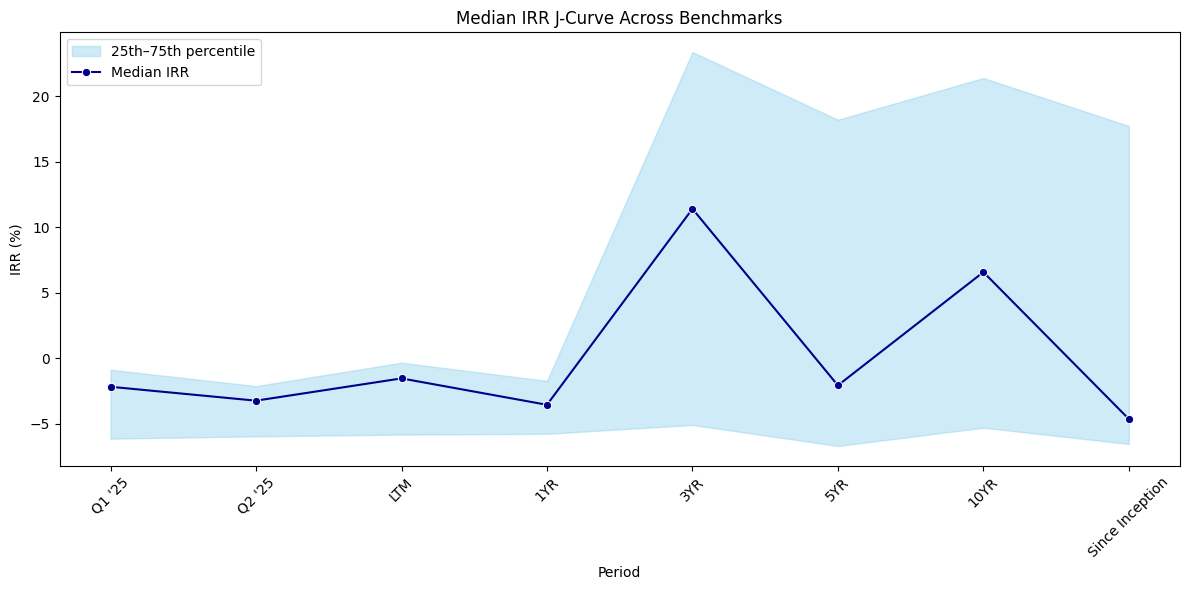

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter to just IRR
irr_df = df_perf[df_perf["METRIC"] == "IRR"].copy()

# 2. Enforce desired x-axis order
period_order = ["Q1 '25", "Q2 '25", "LTM", "1YR", "3YR", "5YR", "10YR", "Since Inception"]
irr_df["PERFORMANCEFREQUENCY"] = pd.Categorical(
    irr_df["PERFORMANCEFREQUENCY"],
    categories=period_order,
    ordered=True
)

# 3. Compute median and quartiles, explicitly setting observed=True
summary = (
    irr_df
    .groupby("PERFORMANCEFREQUENCY", observed=True)["VALUE"]
    .agg(
        median="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 4. Plot the J-curve envelope
plt.figure(figsize=(12, 6))

# shaded 25th–75th percentile area
plt.fill_between(
    summary["PERFORMANCEFREQUENCY"],
    summary["q1"],
    summary["q3"],
    color="skyblue",
    alpha=0.4,
    label="25th–75th percentile"
)

# median line
sns.lineplot(
    data=summary,
    x="PERFORMANCEFREQUENCY",
    y="median",
    marker="o",
    color="darkblue",
    label="Median IRR"
)

plt.title("Median IRR J-Curve Across Benchmarks")
plt.xlabel("Period")
plt.ylabel("IRR (%)")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## How to read the chart

| **Period**            | **Median IRR** | **25th–75th Band** | **What it means**                                               |
|-----------------------|---------------:|-------------------:|-----------------------------------------------------------------|
| **Q1 ’25**            | –2.2 %         | –6.1 % to –1.3 %   | Early‐stage drag from fees + mark-downs                       |
| **Q2 ’25**            | –3.4 %         | –6.0 % to –0.2 %   | Un-realized portfolio effects                                  |
| **LTM** (last 12 mo)  | –1.6 %         | –5.8 % to –0.5 %   | Start of slow recovery                                          |
| **1YR**               | –3.7 %         | –5.0 % to –2.2 %   | J-curve bottom (peak negativity)                               |
| **3YR**               | +11.5 %        | +10.5 % to +23.5 % | “Bend” of the J—positive exits drive returns                    |
| **5YR**               | –2.1 %         | –7.0 % to +18.0 %  | Mid-life variability—some vintages outperform, others underperform |
| **10YR**              | +6.7 %         | –6.0 % to +21.2 %  | Longer-term rebound as more exits crystallize                   |
| **Since Inception**   | –4.6 %         | –6.5 % to +17.6 %  | Early negative years still weigh on lifetime IRR                |


## Key takeaways

1. **Classic J-curve shape**  
   - **Negative/flat** in years 1–2 (left side of the “J”).  
   - **Strong positive inflection** by year 3 (the bottom → upturn).  
   - **Widening dispersion** thereafter (top of the “J”).

2. **Median vs. dispersion**  
   - The **median** line shows what a mid-pack fund experiences.  
   - The **shaded band** reminds you that half of funds lie above/below those medians—dispersion grows over time.

3. **Why use it?**  
   - **LPs** can set realistic expectations for when positive cash flows arrive.  
   - **GPs** can benchmark their funds against peer medians and gauge whether they’re in the top, middle, or bottom half.

---


## **Table 4: BENCHMARKASSOCIATION**

The `BENCHMARKASSOCIATION` table defines the relationship between **venture capital portfolios** and the **benchmarks** they are evaluated against. This association layer serves as the **join table** that connects portfolio-level data with benchmark-level return and characteristic information.

Each row links a portfolio (identified by `PORTFOLIOCODE`) to one of its assigned benchmarks, with an ordinal `RANK` indicating priority.


### Generation Logic

We simulate **100 portfolios** using consistent codes like `FND0001` through `FND0100`, matching the ID scheme used in the `PORTFOLIOGENERALINFORMATION` table.

| Field          | Description                                  |
|----------------|----------------------------------------------|
| `PORTFOLIOCODE` | Internal code for the VC fund (e.g., `FND0012`) |
| `BENCHMARKCODE` | Reference to a benchmark (e.g., `PB_EU_HC`)   |
| `RANK`          | Priority level: 1 (primary), 2 (secondary), 3 (tertiary) |

In [ ]:
import pandas as pd
import random
from IPython.display import display

# 1. Simulate 100 “FNDxxxx” portfolio codes (same as PORTFOLIOGENERALINFORMATION table)
num_portfolios = 100
portfolio_codes = [f"FND{str(i+1).zfill(4)}" for i in range(num_portfolios)]

benchmark_codes = df_benchmark_general["BENCHMARKCODE"].tolist()

# 2. Build the association rows
assoc_rows = []
for fund in portfolio_codes:
    # each fund gets between 1 and 3 distinct benchmarks
    chosen = random.sample(benchmark_codes, k=random.randint(1, 3))
    for rank, bench in enumerate(chosen, start=1):
        assoc_rows.append({
            "PORTFOLIOCODE": fund,
            "BENCHMARKCODE": bench,
            "RANK":          rank
        })

# 3. Create the DataFrame
df_benchmark_association = pd.DataFrame(assoc_rows)

# 4. Validation: ensure no duplicates in fund–benchmark pairing
if df_benchmark_association.duplicated(subset=["PORTFOLIOCODE", "BENCHMARKCODE"]).any():
    raise ValueError("Duplicate PORTFOLIOCODE–BENCHMARKCODE pairs found!")

# 5. Show all rows in the notebook output
pd.set_option('display.max_rows', None)

# Display the full association table
print("BENCHMARKASSOCIATION")
display(df_benchmark_association)


BENCHMARKASSOCIATION


,PORTFOLIOCODE,BENCHMARKCODE,RANK
0,FND0001,CA_HC,1
1,FND0001,PB_CT_2,2
2,FND0001,CA_TE,3
3,FND0002,PB_CT_2,1
4,FND0003,PR_HC,1
5,FND0003,CA_GE,2
6,FND0004,PB_CT,1
7,FND0005,CA_US_TE,1
8,FND0006,PR_HC,1
9,FND0006,PB_NA_GE,2


In [ ]:
# Snowflake SQL table creation

# CREATE TABLE BENCHMARKASSOCIATION (
#     PORTFOLIOCODE   VARCHAR(20),                 -- Simulated fund code (e.g., FND0001)
#     BENCHMARKCODE   VARCHAR(50),                 -- Linked benchmark
#     RANK            NUMBER(1),                   -- Importance: 1=primary, 2=secondary, 3=tertiary

#     PRIMARY KEY (PORTFOLIOCODE, BENCHMARKCODE),
#     FOREIGN KEY (BENCHMARKCODE) REFERENCES BENCHMARKGENERALINFORMATION(BENCHMARKCODE)
#     -- Optionally: add FK to a PORTFOLIOGENERALINFORMATION table if created
# );

---